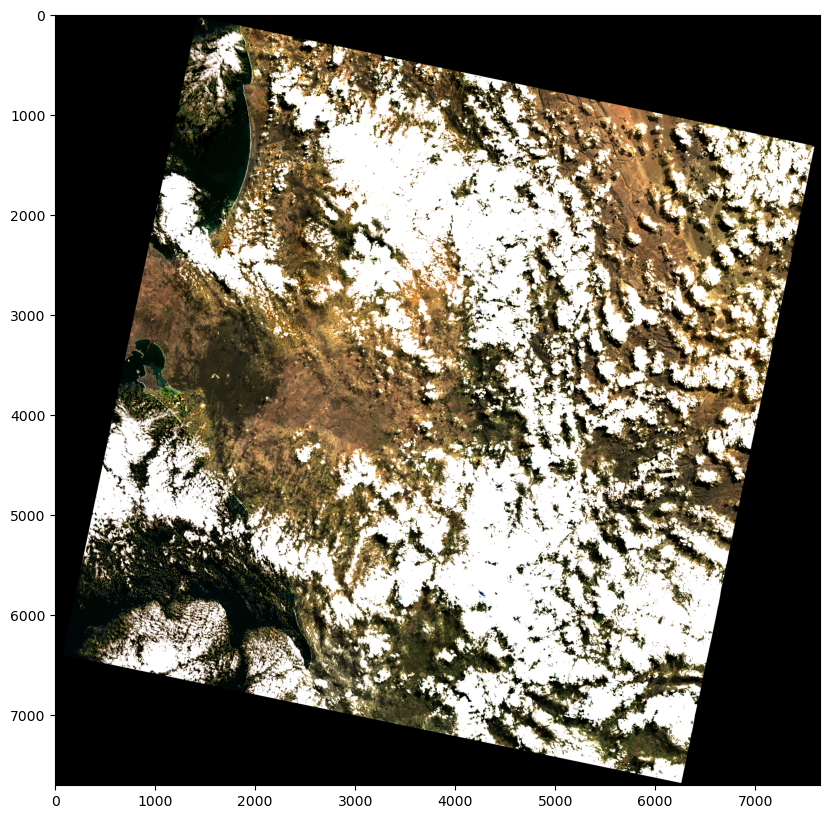

In [6]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt 

def get_RGB(ID):

    # Load Blue (B2), Green (B3) and Red (B4) bands
    B2 = tiff.imread('/Users/deepakkumargupta/Desktop/Minor Project/Small Data /{}/{}_SR_B2.TIF'.format(ID, ID))
    B3 = tiff.imread('/Users/deepakkumargupta/Desktop/Minor Project/Small Data /{}/{}_SR_B3.TIF'.format(ID, ID))
    B4 = tiff.imread('/Users/deepakkumargupta/Desktop/Minor Project/Small Data /{}/{}_SR_B4.TIF'.format(ID, ID))

    # Stack and scale bands
    RGB = np.dstack((B4, B3, B2))         
    RGB = np.clip(RGB*0.0000275-0.2, 0, 1)

    # Clip to enhance contrast
    RGB = np.clip(RGB,0,0.3)/0.3

    return RGB

ID = 'LC09_L2SP_175083_20230410_20230412_02_T1'
RGB = get_RGB(ID)

# Plot the RGB image
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(RGB)
     

In [7]:
def get_mask(val,type='cloud'):
    
    """Get mask for a specific cover type"""

    # convert to binary
    bin_ = '{0:016b}'.format(val)

    # reverse string
    str_bin = str(bin_)[::-1]

    # get bit for cover type
    bits = {'cloud':3,'shadow':4,'dilated_cloud':1,'cirrus':2}
    bit = str_bin[bits[type]]

    if bit == '1':
        return 0 # cover
    else:
        return 1 # no cover

In [8]:
# QA band
QA = tiff.imread('/Users/deepakkumargupta/Desktop/Minor Project/Small Data /{}/{}_QA_PIXEL.TIF'.format(ID, ID))
QA = np.array(QA)

# Get masks
cloud_mask = np.vectorize(get_mask)(QA,type='cloud')
shadow_mask = np.vectorize(get_mask)(QA,type='shadow')
dilated_cloud_mask = np.vectorize(get_mask)(QA,type='dilated_cloud')
cirrus_mask = np.vectorize(get_mask)(QA,type='cirrus')


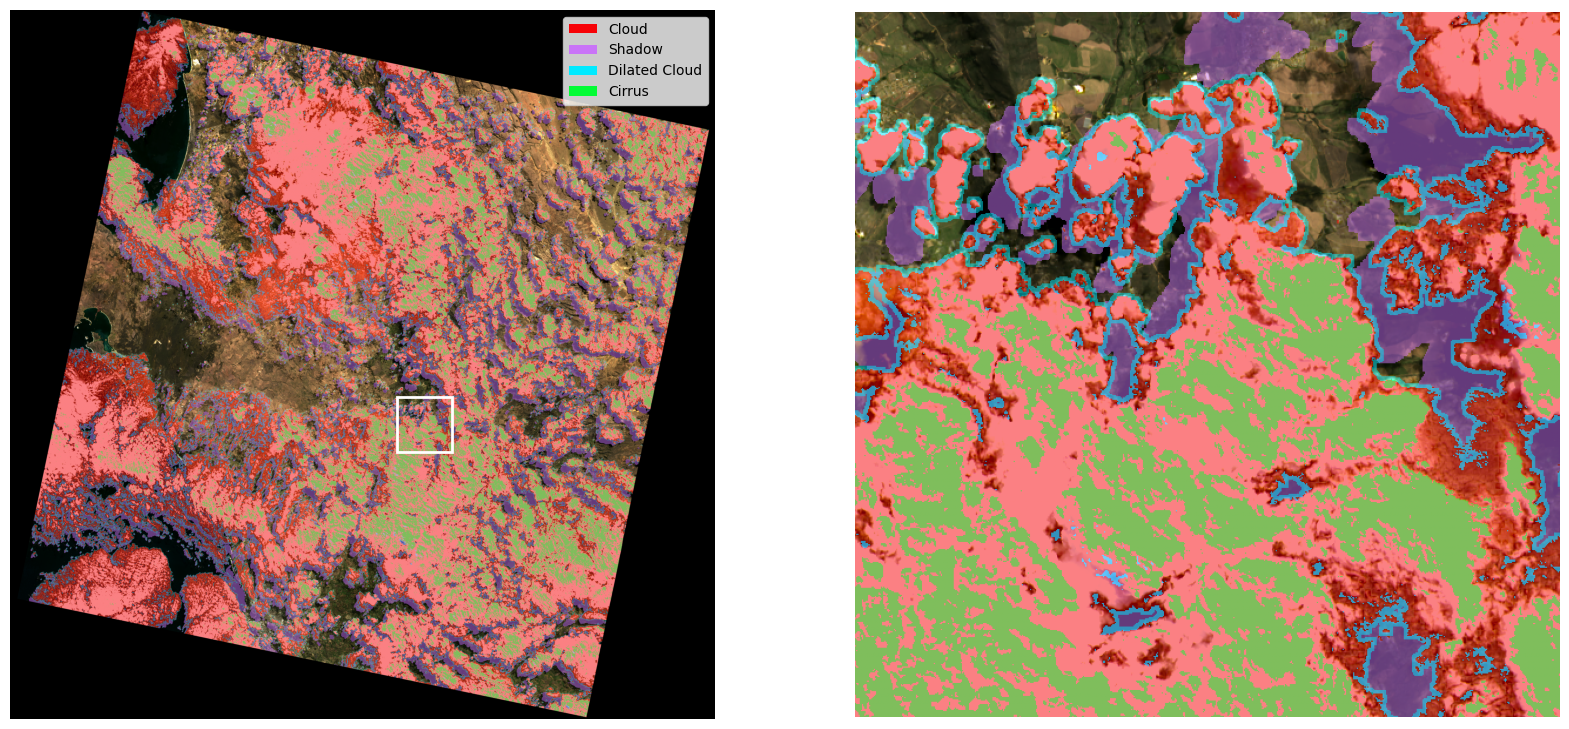

In [9]:
import cv2
import matplotlib as mpl

# segmentation image
seg = RGB.copy()

# color for each cover type
colors = np.array([[247, 2, 7],
                    [201, 116, 247],
                    [0, 234, 255],
                    [3, 252, 53]])/255

masks = [cloud_mask, shadow_mask, dilated_cloud_mask, cirrus_mask]

for i,mask in enumerate(masks):

    # color for cover type
    temp = seg.copy()
    temp[mask == 0] = colors[i]

    # add to segmentation
    seg = cv2.addWeighted(seg, 0.5, temp, 0.5, 0)

fig, ax = plt.subplots(1,2,figsize=(20, 10))

ax[0].imshow(seg)

# add legend with colors for each cover type
legend_elements = [mpl.patches.Patch(facecolor=colors[0], label='Cloud'),
                     mpl.patches.Patch(facecolor=colors[1], label='Shadow'),
                        mpl.patches.Patch(facecolor=colors[2], label='Dilated Cloud'),
                        mpl.patches.Patch(facecolor=colors[3], label='Cirrus')]

ax[0].legend(handles=legend_elements, loc='upper right')

# draw white rectangle around area of interest
h = 300
x,y = 4500,4500
rect = mpl.patches.Rectangle((x-h,y-h),h*2,h*2,linewidth=2,edgecolor='w',facecolor='none')
ax[0].add_patch(rect)

# crop area of interest
crop_seg =  seg[y-h:y+h,x-h:x+h,:]

ax[1].imshow(crop_seg)

ax[0].set_axis_off()
ax[1].set_axis_off()


In [10]:
# crop area of interest
cloud_aoi = cloud_mask[y-h:y+h,x-h:x+h]

# calculate percentage of cloud cover
per_cloud = np.average(1-cloud_aoi)*100
print('Percentage of clouds: {:.2f}%'.format(per_cloud))

Percentage of clouds: 68.96%


In [11]:
# Remove clouds
rm_clouds = RGB*cloud_mask[:, :, np.newaxis]

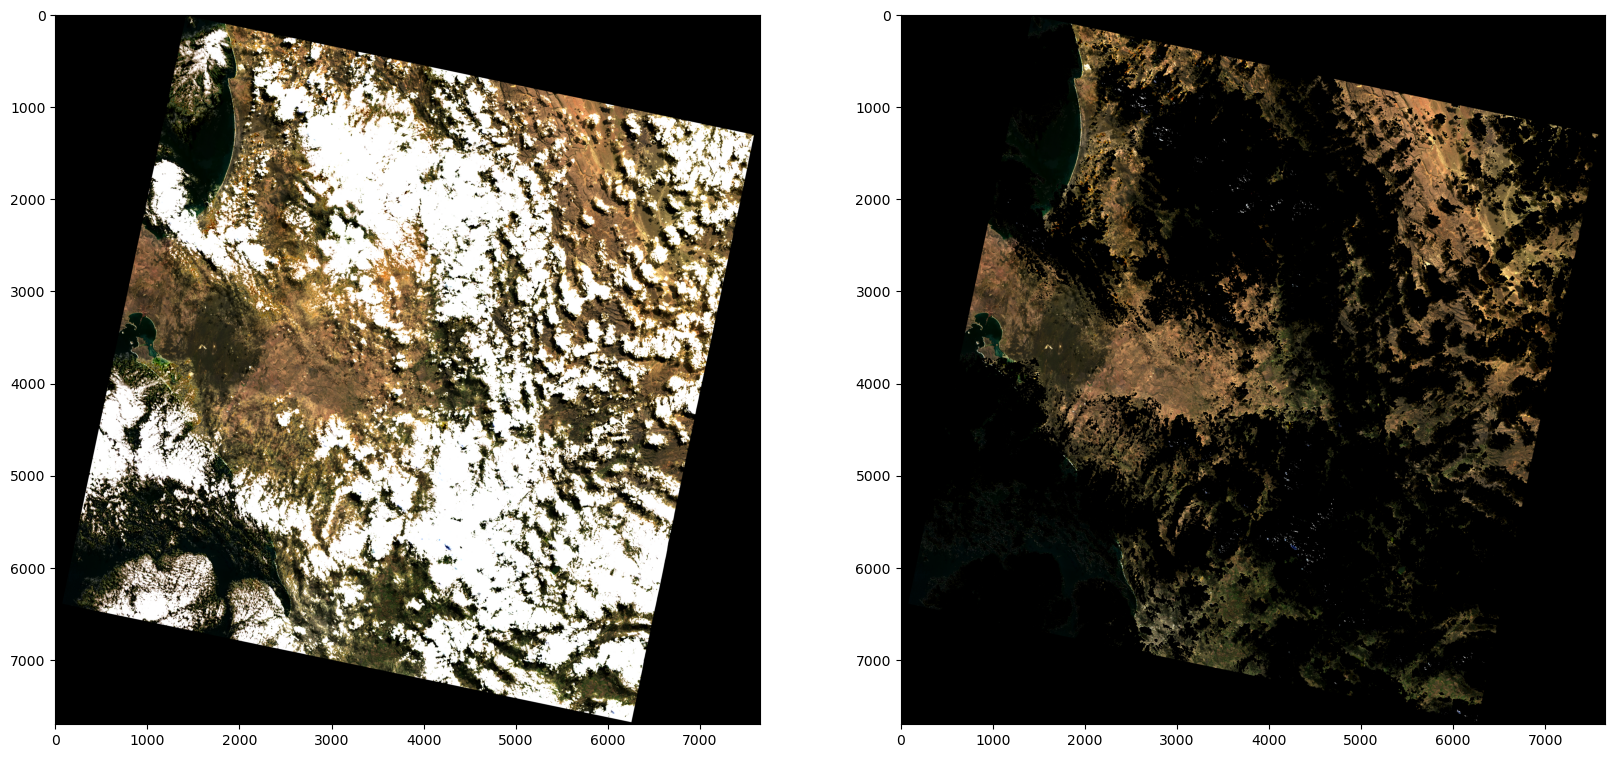

In [13]:
# fig, ax = plt.subplots(1,2,figsize=(20, 10))
# ax[0].imshow(rm_clouds)
fig, ax = plt.subplots(1,2,figsize=(20, 10))

ax[0].imshow(RGB)
ax[1].imshow(rm_clouds)